In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/10708/

/content/drive/MyDrive/10708


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%cp .kaggle/kaggle.json /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/stock-market-data

 99% 1.02G/1.03G [00:09<00:00, 79.1MB/s]
100% 1.03G/1.03G [00:09<00:00, 121MB/s] 


In [ ]:
!unzip *.zip

# LSTM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = pd.read_csv('stock_market_data/nasdaq/csv/AAPL.csv')
# df = pd.read_csv('stock_market_data/forbes2000/csv/A.csv')

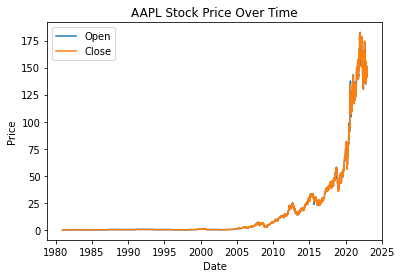

In [ ]:
import matplotlib.pyplot as plt

# Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y" )

# Plot the 'Open' column over time
plt.plot(df['Date'], df['Open'], label='Open')
plt.plot(df['Date'], df['Close'], label='Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.title('AAPL Stock Price Over Time')
plt.show()

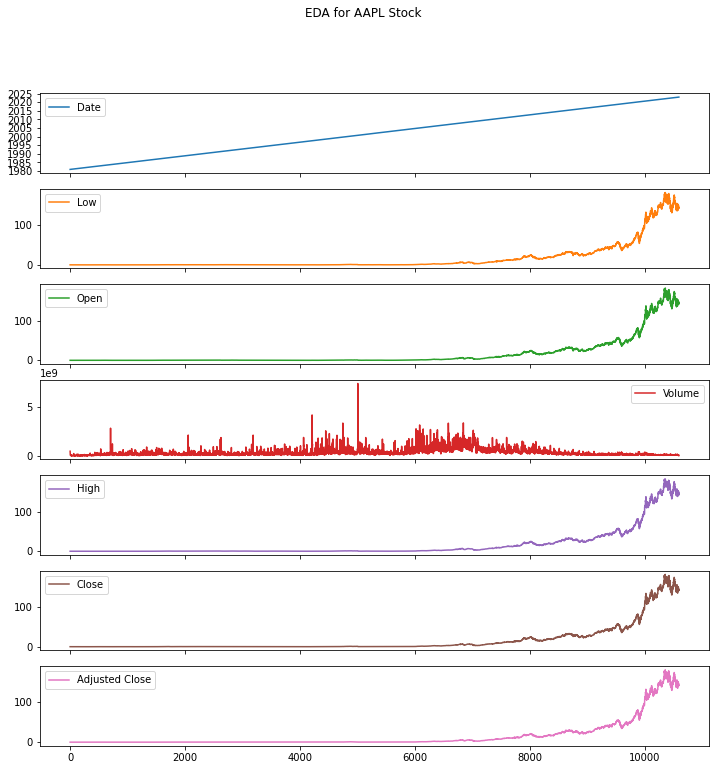

In [ ]:
df.plot(legend=True,subplots=True, title="EDA for AAPL Stock", figsize = (12, 12))
plt.show()

In [ ]:
df.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,1980-12-12,0.128348,0.128348,469033600,0.128906,0.128348,0.099874
1,1980-12-15,0.121652,0.122210,175884800,0.122210,0.121652,0.094663
2,1980-12-16,0.112723,0.113281,105728000,0.113281,0.112723,0.087715
3,1980-12-17,0.115513,0.115513,86441600,0.116071,0.115513,0.089886
4,1980-12-18,0.118862,0.118862,73449600,0.119420,0.118862,0.092492


In [ ]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

X = []
Y = []
window_size=100
pred_window_size = 30

for i in (range(1, len(df) - window_size - pred_window_size -1 , 1)):
    # index 2 is for open
    idx = 5
    first = df.iloc[i,idx]
    temp = []
    temp2 = []
    for j in (range(window_size)):
        temp.append((df.iloc[i + j, idx] - first) / first)
    for j in (range(pred_window_size)):
        temp2.append((df.iloc[i + window_size + j, idx] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(30, 1))

In [ ]:
train_ratio = 0.80
test_ratio = 0.10
validation_ratio = 0.10

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=test_ratio,
                                                    random_state=708)

train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y, 
                                                      test_size=validation_ratio/(train_ratio+test_ratio),
                                                      random_state=708)

train_X = np.array(train_X)
test_X = np.array(test_X)
train_Y = np.array(train_Y)
test_Y = np.array(test_Y)
valid_X = np.array(valid_X)
valid_Y = np.array(valid_Y)

print(train_X.shape, train_Y.shape)
print(test_X.shape, test_Y.shape)
print(valid_X.shape, valid_Y.shape)


(8366, 100, 1) (8366, 30, 1)
(1046, 100, 1) (1046, 30, 1)
(1046, 100, 1) (1046, 30, 1)


In [ ]:
print(train_X.shape)
train_X = np.squeeze(train_X)
valid_X = np.squeeze(valid_X)
test_X = np.squeeze(test_X)
train_Y = np.squeeze(train_Y)
valid_Y = np.squeeze(valid_Y)
test_Y = np.squeeze(test_Y)
# train_X = train_X.reshape(train_X.shape[0], 1, 100, 1)
# valid_X = valid_X.reshape(valid_X.shape[0], 1, 100, 1)
# test_X = test_X.reshape(test_X.shape[0], 1, 100, 1)

print(train_X.shape, train_Y.shape)
print(test_X.shape, test_Y.shape)
print(valid_X.shape, valid_Y.shape)

(8366, 100)
(8366, 100) (8366, 30)
(1046, 100) (1046, 30)
(1046, 100) (1046, 30)


In [ ]:
# For creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

model = tf.keras.Sequential()

# Creating the Neural Network model here...
# CNN layers
model.add((Conv1D(64, kernel_size=3, activation='relu', input_shape=(100, 1))))
model.add((MaxPooling1D(2)))
model.add((Conv1D(128, kernel_size=3, activation='relu')))
model.add((MaxPooling1D(2)))
model.add((Conv1D(64, kernel_size=3, activation='relu')))
model.add((MaxPooling1D(2)))
# model.add((Flatten()))
# model.add(Dense(5, kernel_regularizer=L2(0.01)))

# LSTM layers
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))

# #Final layers
model.add(Dense(30, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

history = model.fit(train_X, train_Y, validation_data=(valid_X,valid_Y), epochs=40,batch_size=40, verbose=1, shuffle =True)

Epoch 1/40
210/210 [==============================] - 24s 20ms/step - loss: 0.0449 - mse: 0.0449 - mae: 0.1528 - val_loss: 0.0395 - val_mse: 0.0395 - val_mae: 0.1480
Epoch 2/40
210/210 [==============================] - 3s 13ms/step - loss: 0.0309 - mse: 0.0309 - mae: 0.1271 - val_loss: 0.0259 - val_mse: 0.0259 - val_mae: 0.1149
Epoch 3/40
210/210 [==============================] - 3s 14ms/step - loss: 0.0278 - mse: 0.0278 - mae: 0.1201 - val_loss: 0.0263 - val_mse: 0.0263 - val_mae: 0.1163
Epoch 4/40
210/210 [==============================] - 3s 16ms/step - loss: 0.0269 - mse: 0.0269 - mae: 0.1181 - val_loss: 0.0230 - val_mse: 0.0230 - val_mae: 0.1080
Epoch 5/40
210/210 [==============================] - 3s 13ms/step - loss: 0.0252 - mse: 0.0252 - mae: 0.1142 - val_loss: 0.0246 - val_mse: 0.0246 - val_mae: 0.1125
Epoch 6/40
210/210 [==============================] - 3s 13ms/step - loss: 0.0252 - mse: 0.0252 - mae: 0.1148 - val_loss: 0.0254 - val_mse: 0.0254 - val_mae: 0.1140
Epoch 7/4

In [ ]:
# For creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

model = tf.keras.Sequential()

# Creating the Neural Network model here...
# CNN layers
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
# model.add(Dense(5, kernel_regularizer=L2(0.01)))

# LSTM layers
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))

#Final layers
model.add(Dense(30, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

history = model.fit(train_X, train_Y, validation_data=(valid_X,valid_Y), epochs=40,batch_size=40, verbose=1, shuffle =True)

Epoch 1/40


ValueError: ignored

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_29 (Conv1D)          (None, 98, 64)            256       
                                                                 
 max_pooling1d_28 (MaxPoolin  (None, 49, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_30 (Conv1D)          (None, 47, 128)           24704     
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, 23, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_31 (Conv1D)          (None, 21, 64)            24640     
                                                                 
 max_pooling1d_30 (MaxPoolin  (None, 10, 64)         

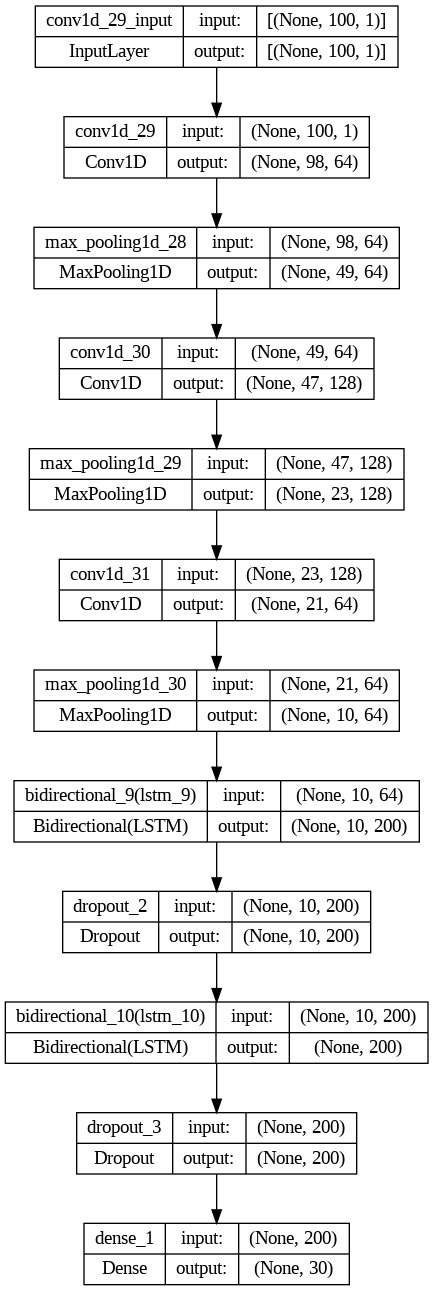

In [ ]:
from tensorflow.keras.utils import plot_model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

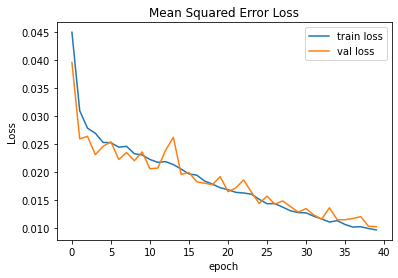

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Mean Squared Error Loss")
plt.legend()

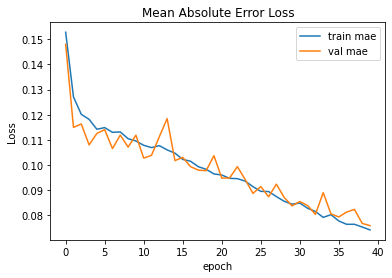

In [ ]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Mean Absolute Error Loss")
plt.legend()

In [ ]:
model.evaluate(test_X, test_Y)

33/33 [==============================] - 0s 8ms/step - loss: 0.0102 - mse: 0.0102 - mae: 0.0765


[0.010210920125246048, 0.010210920125246048, 0.07651025056838989]

In [ ]:
predicted  = model.predict(test_X)
# predicted = np.array(predicted[:,0]).reshape(-1,1)

33/33 [==============================] - 2s 5ms/step


In [ ]:
lastday = np.copy(np.array(predicted[:,-1])).reshape(-1,1)

In [ ]:
nextday = np.copy(np.array(predicted[:,0])).reshape(-1,1)

In [ ]:
nextday

array([[0.00433581],
       [0.18476203],
       [0.08348032],
       ...,
       [0.19852684],
       [0.2018323 ],
       [0.13243502]], dtype=float32)

In [ ]:
test_Y[:,0]

array([[0.16201605],
       [0.22420333],
       [0.0995491 ],
       ...,
       [0.18032794],
       [0.16863832],
       [0.09082717]])

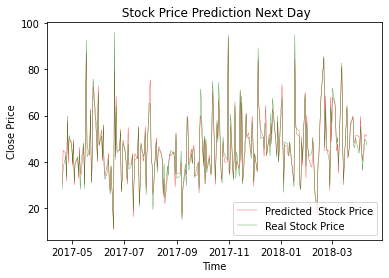

In [ ]:
test_label = np.copy(test_Y[:,0]).reshape(-1,1)
nextday = np.copy(np.array(predicted[:,0])).reshape(-1,1)
len_t = len(train_X)

for j in range(len_t , len_t + len(test_X)):
    first = df.iloc[j,idx]
    # input is normalized difference. df.iloc[i + j, 2] - first) / first
    test_label[j - len_t] = test_label[j - len_t] * first + first
    nextday[j - len_t] = nextday[j - len_t] * first + first

dates = (df['Date'][len_t+1:len_t + len(test_X) + 1])
plt.plot(dates[800:], nextday[800:], color = 'red', label = 'Predicted  Stock Price', linewidth=0.3)
plt.plot(dates[800:], test_label[800:], color = 'green', label = 'Real Stock Price', linewidth=0.3)
plt.title(' Stock Price Prediction Next Day')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
test_label = np.copy(test_Y[:,0]).reshape(-1,1)
nextday = np.copy(np.array(predicted[:,0])).reshape(-1,1)